# Convolutional Neural Networks

По русски называется сверточной нейронной сетью. 

Используется для эффективной распознавание образов. Такие нейросети используются для работы с изображениями. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
#блокируем всплавание о предупреждениях
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

## Data Preprocessing

The images included in the data/cats-and-dogs directory are a random subset of the full cat anddog data set from the following Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats/data

In [2]:
# организуем нашу выборку, разделяем на train, valid, test подвыборки

#заходим в папку с данными
os.chdir('data/dog-vs-cat')
#проверяем наличие созданных папок, если нет
if os.path.isdir('train/dog') is False:
    #создаем необходимые папки
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    for c in random.sample(glob.glob('cat*'), 500):
        shutil.move(c, 'train/cat')
    for c in random.sample(glob.glob('dog*'), 500):
        shutil.move(c, 'train/dog')
    for c in random.sample(glob.glob('cat*'), 100):
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob('dog*'), 100):
        shutil.move(c, 'valid/dog')
    for c in random.sample(glob.glob('cat*'), 50):
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob('dog*'), 50):
        shutil.move(c, 'test/dog')
        
#выходим из папки
os.chdir('../../')

In [3]:
TRAIN_PATH = 'data/dog-vs-cat/train'
VALID_PATH = 'data/dog-vs-cat/valid'
TEST_PATH  = 'data/dog-vs-cat/test'

In [4]:
#предобработка файлов под формат модели vgg16
#все рисунки приводятся к единому размеру, цветовой гамме и т.п. Это необходимо для того, чтобы модели было проще обучиться
#к тому же у нас рисунки разных размеров и разного качества. 
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=TRAIN_PATH, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=VALID_PATH, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=TEST_PATH, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Код, который приведен ниже нужен для того, чтобы проверить, что у нас была правильно подобрана выборка, ничего ен исчезло и т.п. 

В случае если что-то отличается по каким-то причинам, то программа выдаст ошибку

In [5]:
#удостоверимся, что число файлов в train_batches = 1000
assert train_batches.n == 1000
#удостоверимся, что число файлов в valid_batches = 200
assert valid_batches.n == 200
#удостоверимся, что число файлов в test_batches = 100
assert test_batches.n  == 100
#проверяем, чтобы число классов было равно 2, во всех подвыборках
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [6]:
imgs, labels = next(train_batches)

In [7]:
# This function will plot images in the form of a grid with 1 row and 10 column where imags are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

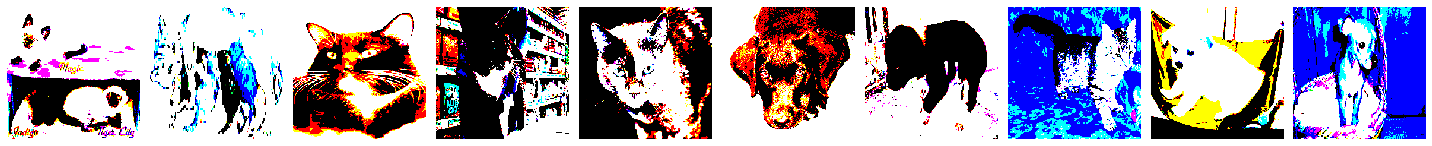

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [8]:
plotImages(imgs)
print(labels)

## Build and train a CNN

In [11]:
model = Sequential([
    #входной слой
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    #этот слой урезает картинку вдвое. 
    MaxPool2D(pool_size=(2,2), strides=2),    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    #переводим все измерения матрицы в одну плоскость. 
    Flatten(),
    #выходной слой. Т.к. у нас только 2 класса, мы используем units=2
    Dense(units=2, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 26s - loss: 15.1253 - acc: 0.5730 - val_loss: 14.4254 - val_acc: 0.5200
Epoch 2/10
100/100 - 25s - loss: 2.7023 - acc: 0.7380 - val_loss: 3.0107 - val_acc: 0.6700
Epoch 3/10
100/100 - 25s - loss: 0.3981 - acc: 0.9100 - val_loss: 2.9786 - val_acc: 0.6300
Epoch 4/10
100/100 - 25s - loss: 0.0928 - acc: 0.9790 - val_loss: 2.8211 - val_acc: 0.6050
Epoch 5/10
100/100 - 25s - loss: 0.0182 - acc: 0.9940 - val_loss: 2.6893 - val_acc: 0.6450
Epoch 6/10
100/100 - 27s - loss: 0.0306 - acc: 0.9900 - val_loss: 2.7715 - val_acc: 0.6550
Epoch 7/10
100/100 - 27s - loss: 0.0033 - acc: 0.9990 - val_loss: 2.6963 - val_acc: 0.6600
Epoch 8/10
100/100 - 28s - loss: 5.2947e-04 - acc: 1.0000 - val_loss: 2.6946 - val_acc: 0.6700
Epoch 9/10
100/100 - 28s - loss: 3.3575e-04 - acc: 1.0000 - val_loss: 2.6946 - val_acc: 0.6650
Epoch 10/10
100/100 - 28s - loss: 2.9373e-04 - acc: 1.0000 - val_loss: 2.6952 - val_acc: 0.6700


## Predict